# **Avance 4. Modelos Alternativos**

## **Equipo #5**

**Integrantes y matriculas**

* Isaac Manriquez Calderon - A01206674
* Marcos Eduardo Garcia Ortiz - A01276213
* Jesus David Talamantes Morales - A01706335

In [75]:
# Importar Librerias.
# Comando para recargar cambios en librerias automaticamente.
%load_ext autoreload 
%autoreload 2

# Librerias para el manejo del ambiente y documentos
import sys, os
from pathlib import Path
sys.path.append(os.path.abspath(os.path.join('..')))

# Librerias generales de matematicas
import numpy as np
import matplotlib.pyplot as plt 

# Librerias Locales del Repositorio.
from watermark.dataset import DataHandler
from watermark.features import Utilities
from watermark.plots import PlotHandler

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Fase 0. Generar DataSet de Imagenes.

### 1. Transformar los Datos a Imagenes - DONE
- Vamos a generar una base de datos de imagenes utilizando los datos de X, Y y Presion que estan dentro de la base de datos PKL.

In [7]:
# Vamos a sacar los datos del Dataset.
# Cargamos los datos del Dataset.
data_h = DataHandler() #Objeto que maneja datos.
data_dict = data_h.load_data(Path("../data/raw"), "emothaw_data.pkl")

2025-02-11 23:21:35.938 | INFO     | watermark.dataset:load_data:51 - Loading data from ..\data\raw\emothaw_data.pkl
2025-02-11 23:21:37.268 | SUCCESS  | watermark.dataset:load_data:56 - Data loaded successfully from ..\data\raw\emothaw_data.pkl


In [142]:
# Sacamos los 
x_data_in = {} # Diccionario de Puntos en X por tarea.
y_data_in = {} # Diccionario de Puntos en Y por Tarea.
p_data_in = {} # Diccionario de Presion en cada momento por tarea.
for key in data_dict.keys():
    x_data_in[key] = [serie.X for serie in data_dict[key]] 
    y_data_in[key] = [serie.Y for serie in data_dict[key]] 
    p_data_in[key] = [serie.Pressure for serie in data_dict[key]] 


In [ ]:
# Generamos una copia en forma de lista de los datos en los diccionarios.
names_list = list(data_dict.keys())
list_data_x = [x_data_in[key] for key in names_list]
list_data_y = [y_data_in[key] for key in names_list]
list_data_p = [p_data_in[key] for key in names_list]
print("Número de Tareas:", len(list_data_x))
print("Número de Usuarios realizadas:", len(list_data_x[0]))
print("Número de Muestras por Tarea:", len(list_data_x[0][0]))


Número de Tareas: 7
Número de Usuarios realizadas: 129
Número de Muestras por Tarea: 1474
129


In [160]:
# Convertir a una funcion
# def get_image(task_id, user_id,  )
# Aqui vamos a crear una imagen usando SNS
for num_tarea in range(7):
  data_lenght = len(list_data_x[num_tarea])
  for num_usuario in range(data_lenght):
    # num_tarea = 5
    # num_usuario = 7

    # Datos de coordenadas del dibujo
    datos_x = list_data_x[num_tarea][num_usuario].to_numpy()
    datos_y = list_data_y[num_tarea][num_usuario].to_numpy()

    # Datos de presion del lapiz usado
    datos_p = list_data_p[num_tarea][num_usuario].to_numpy()

    # Reasignamos los valores de X y Y a nan ya que solo nos interesa cuando presiona el lapiz en el papel
    datos_x[datos_p == 0] = np.nan
    datos_y[datos_p == 0] = np.nan

    # Invertimos los datos de X para mejor visualizacion
    datos_x_inv = -datos_x[:]

    plt.axis('off') # Apagamos los axis de la imagen
    plt.plot(datos_x_inv, datos_y, linewidth= 1, color='k') # Imprimimos la imagen
    plt.subplots_adjust(left=0, right=1, bottom= 0, top=1) # Centramos la imagen


    # Salvamos la imagen
    figure = plt.gcf() # Sacamos la imagen actual
    figure.set_size_inches(2.24, 2.24)

    # when saving, specify the DPI
    # Generamos el nombre para nuestro dataset.
    file_name = f"task{num_tarea}_user_{num_usuario}.png"
    plt.savefig("DataSet/" + file_name, dpi = 100)
    plt.close()


### 2. Implementar una ResNet101 - Pre-Entrenada
- Vamos a utilizar una modelos pre-entrenado de la red neuronal denominada ResNet101, con la cual obtendremos las caracteristicas principales de las imagenes en un vector de 2048 valores. - Feature Vector


In [167]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet import preprocess_input
import numpy as np
import os

# 1. Load the pre-trained ResNet101 model (excluding the top classification layer)
base_model = ResNet101(weights='imagenet', include_top=False, pooling='avg') # 'avg' pooling is important!

# 2. Set the model to non-trainable (inference mode)
base_model.trainable = False

# 3. Path to your image directory
image_dir = "DataSet"  # Replace with the actual path

# 4. Store the outputs
outputs = []

# Loop through all images
for filename in os.listdir(image_dir):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg')): #check for image file
        image_path = os.path.join(image_dir, filename)
        try:
            # 5. Load and preprocess the image
            img = image.load_img(image_path, target_size=(224, 224)) # ResNet input size
            x = image.img_to_array(img)
            x = np.expand_dims(x, axis=0)  # Create a batch (batch size 1)
            x = preprocess_input(x)       # Important: Apply ResNet's preprocessing

            # 6. Get the output (fc_1000 equivalent)
            features = base_model.predict(x)
            outputs.append(features)

        except Exception as e:
            print(f"Error processing image {filename}: {e}")

# # 7. Convert to a single NumPy array
# all_outputs = np.concatenate(outputs, axis=0)
# print("Shape of all outputs:", all_outputs.shape) # Should be (902, 2048) for ResNet101

# # 8. Save the features (optional but recommended)
# np.save("resnet101_features.npy", all_outputs)

171446536/171446536 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
1/1 ━━━━━━━━━━

In [174]:
print(len(outputs))
print(len(outputs[100][0]))

num_img = 100
img_features = outputs[num_img][0]

902
2048


Important Note: The fc_1000 layer itself has 1000 outputs (corresponding to the 1000 ImageNet classes). However, you're not using this layer directly for feature extraction. You are using the output before this layer (after the last convolutional block and average pooling) which has 2048 channels.
Therefore, even though the final classification layer is called fc_1000, the feature vectors you extract from the convolutional part of the network will have a dimensionality of 2048. This is the standard and correct way to use pre-trained ResNet models for feature extraction

### 3. Implementar una ResNet101 - Pre-Entrenada
- Vamos a utilizar una modelos pre-entrenado de la red neuronal denominada ResNet101, con la cual obtendremos las caracteristicas principales de las imagenes en un vector de 2048 valores. - Feature Vector


##  Fase 1. Implementar un Master Share Generator Basico

In [124]:
# Importar Librerias
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.applications.resnet import preprocess_input

# Librerias Locales del Repositorio.
from watermark.dataset import DataHandler
from watermark.features import Utilities
from watermark.plots import PlotHandler

plot = PlotHandler()

**Implementación Basada en Articulo**
- Fierro-Radilla, A., Nakano-Miyatake, M., Cedillo-Hernandez, M., Cleofas-Sanchez, L., & Perez-Meana, H. (2019). A Robust Image Zero-watermarking using Convolutional Neural Networks. 2019 7th International Workshop on Biometrics and Forensics (IWBF). doi:10.1109/iwbf.2019.8739245 


In [85]:
# Adaptar ResNet101 Pre-Entrenada para Feature Extraction

# Cargamos el modelo pre-entrenado de ResNet101
ResNet101_model = ResNet101(weights='imagenet', include_top=False, pooling='avg') 
ResNet101_model.trainable = False # Guardamos los parametros
# Tomamos la utilma capa de la ResNet y le agregamos una capa Densa con la forma 
# nuestro watermark
x = ResNet101_model.output 
x = Dense(152, activation=None)(x)

main_model = Model(inputs=ResNet101_model.input, outputs=x)

In [114]:
# Preparamos una Imagen de Prueba.
img_num = np.random.randint(129)
image_path = f'DataSet/task0_user_{img_num}.png'
print('Imagen a Usar', image_path)

# Cargamos la imagen en el modelo para generar sus features.
img = image.load_img(image_path, target_size=(224, 224)) # ResNet input size
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)  # Create a batch (batch size 1)
x = preprocess_input(x)

# Realizamos una prediccion con el modelo y obtenemos las Features
features = main_model.predict(x)[0]

Imagen a Usar DataSet/task0_user_42.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Largo de Features:  152
Valores Features: [1. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1.]


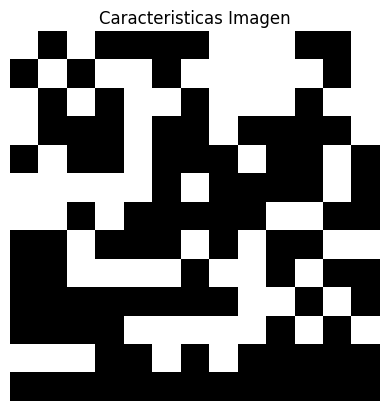

In [128]:
# Filtrado del Vector Features a Binario
features[features > 0] = 1
features[features <= 0] = 0
print('Largo de Features: ', len(features))
print('Valores Features:', features[::10])

# Mostrar la Features en formato de Matrix
plot.plot_master(features, 'Caracteristicas Imagen')

Fecha a Utilizar:  2007/04/01 13:33:16
Largo de Fecha:  152
Valores Fecha: [0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1]


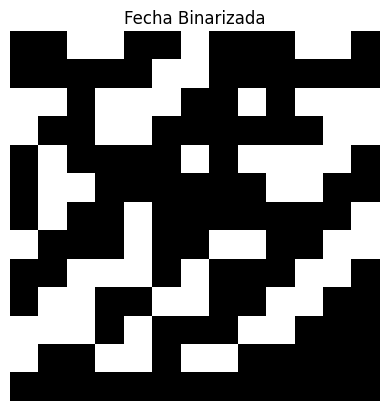

In [129]:
# Generador de WaterMarks usando Fechas
utils = Utilities()
# Generamos 10 Fechas Aleatorias
date = utils.dates_generator(1)[0]
print('Fecha a Utilizar: ', date)
date_bin = utils.string2bit(date)
print('Largo de Fecha: ', len(date_bin))
print('Valores Fecha:', date_bin[::10])

# Mostrar la Master Share en formato de Matrix
plot.plot_master(date_bin, 'Fecha Binarizada')

Largo de Master Share:  152
Valores Master Share: [1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0]


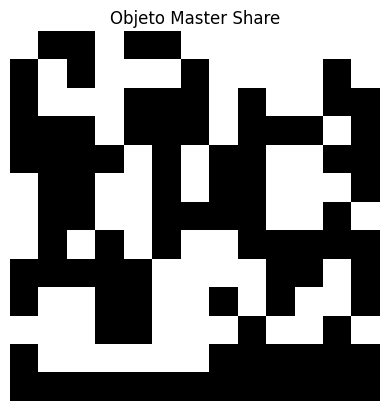

In [130]:
# Generamos el Master Share utilizando una operacion XOR
master_share = utils.array_xor(date_bin, features)
print('Largo de Master Share: ', len(master_share))
print('Valores Master Share:', master_share[::10])

plot.plot_master(master_share, 'Objeto Master Share')

## Fase 2. Implementar Image Verificator

In [119]:
# Utilizamos el mismo modelo de toma de Features.

# # Preparamos una Imagen de Prueba.
# img_num = np.random.randint(129)
# image_path2 = f'DataSet/task0_user_{img_num}.png'
# print('Imagen a Usar', image_path2)

# Vamos a usar la misma imagen.
print('Imagen a Usar', image_path)

# Cargamos la imagen en el modelo para generar sus features.
img = image.load_img(image_path, target_size=(224, 224)) # ResNet input size
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)  # Create a batch (batch size 1)
x = preprocess_input(x)

# Realizamos una prediccion con el modelo y obtenemos las Features
features = main_model.predict(x)[0]

Imagen a Usar DataSet/task0_user_42.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


In [120]:
# Filtrado del Vector Features a Binario
features[features > 0] = 1
features[features <= 0] = 0
print('Largo de Features: ', len(features))
print('Valores Features:', features[::10])

Largo de Features:  152
Valores Features: [1. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1.]


In [121]:
# Regeneramos la WaterMark aplicando un XOR entre las 
# features de la imagen y la mastershare
watermark = utils.array_xor(master_share, features)
print('Largo de Master Share: ', len(watermark))
print('Valores Master Share:', watermark[::10])

Largo de Master Share:  152
Valores Master Share: [0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1]


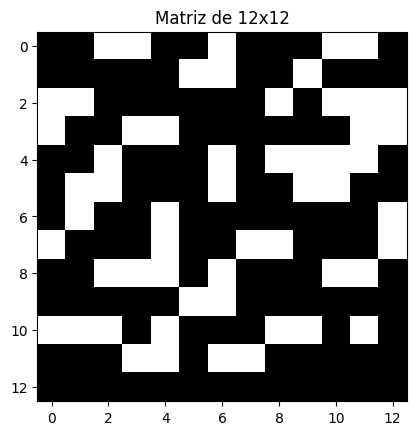

In [122]:
# Mostrar la Master Share en formato de Matrix
plot = PlotHandler()
plot.plot_master(watermark)

In [123]:
print(utils.bit2string(watermark))

2020/02/11 11:00:46


Añadir explicacion de los LH 

Fase 1. Implementar "Feature Vector"

1. 
2. Implementar una ResNet101 pre-entrenada que genere un vector de 1000 features. --> img_features
3. Implementarle el DWT a las 1000 features. --> dwt_features
4. Implementar el DCT a el output de DWT. --> dct_matrix
5. Aplicar un HASH --> feature_vector

Fase 2. Implementar Watermark
1. Generar las fechas --> datetime.
2. Pasarlo por un Hash (Encriptar) --> water_matrix

Fase 3. Obtener el "Logical Key Vector"
1. Aplicar un XOR a el feature_vector con water_matrix

Fase 4. Detección de WaterMark
1. Por definir....